# Installation

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -q -i 0 | grep "Product Name"
#https://drive.google.com/drive/folders/1_kHJFZ_31Pa4fOPeovChvuLt-xj-B6h-?usp=sharing
%cd /content/drive/MyDrive/MaskRCNN_wandb

    Product Name                          : Tesla T4
/content/drive/MyDrive/MaskRCNN_wandb


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install keras==2.1.6

In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf
print("tf", tf.__version__) #1.5.2 -> 1.15.0
import keras
print("keras", keras.__version__) #2.2.5 -> 2.1.6 req
import numpy as np
print("np", np.__version__) #1.20.0
import scipy
print("scipy", scipy.__version__) #1.2.2

TensorFlow 1.x selected.
tf 1.15.2
keras 2.1.6
np 1.20.0
scipy 1.2.2


Using TensorFlow backend.


In [ ]:
!wandb init

This directory has been configured previously, should we re-configure it? [y/N]: y
wandb: Which project should we use?
wandb: (1) honda_3551
wandb: (2) toyotamodel
wandb: (3) hondamodel
wandb: (4) Create New
wandb: Enter your choice: 4
wandb: You chose 'Create New'
Enter a name for your new project: toyota_first_run
This directory is configured!  Next, track a run:
* In your training script:
    import wandb
    wandb.init(project="toyota_first_run")
* then `python <train.py>`.



# Configuration

In [ ]:
%cd /content/drive/MyDrive/MaskRCNN_wandb

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://drive.google.com/drive/folders/1x4qge_ixK6dyYTj8mjQBRgIrVR5L20uM?usp=sharing
DATASET_PATH = '/content/drive/MyDrive/Toyota first run'

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.model import load_image_gt
import matplotlib.pyplot as plt
# Root directory of the project
# ROOT_DIR = os.path.abspath("/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN_wandb")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + (13 Car model)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 643
    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_MAX_INSTANCES = 1

    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    # BATCH_SIZE = 1
    VALIDATION_STEPS = 71
    BACKBONE = "resnet101"

    # RPN_ANCHOR_SCALES  = [16, 32, 64, 128, 256]
    # MODEL TUNING
    if os.environ.get('BACKBONE'):
        BACKBONE = os.environ.get('BACKBONE')
    if os.environ.get('GRADIENT_CLIP_NORM'):
        GRADIENT_CLIP_NORM = float(os.environ.get('GRADIENT_CLIP_NORM'))
    if os.environ.get('LEARNING_RATE'):
        LEARNING_RATE = float(os.environ.get('LEARNING_RATE'))
    if os.environ.get('WEIGHT_DECAY'):
        WEIGHT_DECAY = float(os.environ.get('WEIGHT_DECAY'))
    def get_config_dict(self):
        """Return Configuration values as a dictionary for the sake of syncing with wandb"""
        d = {}
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                d[a] = getattr(self, a)
        return d

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "ALTIS")
        self.add_class("object", 2, "CAMRY")
        self.add_class("object", 3, "CHR")
        self.add_class("object", 4, "FORTUNER")
        self.add_class("object", 5, "REVO 1 ตอน")
        self.add_class("object", 6, "REVO 1 ตอนครึ่ง")
        self.add_class("object", 7, "REVO 2 ตอน")
        self.add_class("object", 8, "VIGO 1 ตอน")
        self.add_class("object", 9, "VIGO 1 ตอนครึ่ง")
        self.add_class("object", 10, "VIGO 2 ตอน")
        self.add_class("object", 11, "VIOS")
        self.add_class("object", 12, "YARIS")
        self.add_class("object",13, "YARISATIV")


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"ALTIS": 1,"CAMRY": 2, "CHR":3, "FORTUNER":4, "REVO 1 ตอน":5, "REVO 1 ตอนครึ่ง":6, "REVO 2 ตอน":7, 
                         "VIGO 1 ตอน":8, "VIGO 1 ตอนครึ่ง":9, "VIGO 2 ตอน":10, "VIOS":11, "YARIS":12, "YARISATIV":13} 
                         
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  256
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           object
NUM_CLASSES                    14
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [ ]:
## Define some global constants

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN_wandb")
# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
if os.path.exists(DEFAULT_LOGS_DIR)==False:
    os.mkdir(DEFAULT_LOGS_DIR)
    
## Download pretrained COCO Model!
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom(DATASET_PATH, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(DATASET_PATH, "val")
dataset_val.prepare()

objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['ALTIS']
objects: ['A

In [ ]:
import wandb
import matplotlib.pyplot as plt
import keras
import scipy
run = wandb.init(project="toyota_first_run", resume=True)
_config = CustomConfig()

config_dict = _config.get_config_dict()
configs_of_interest = ['BACKBONE', 'GRADIENT_CLIP_NORM', 'LEARNING_MOMENTUM', 'LEARNING_RATE',
                        'WEIGHT_DECAY', 'STEPS_PER_EPOCH']

wandb.log({k: config_dict[k] for k in configs_of_interest})


def fig_to_array(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    buf = np.roll(buf, 3, axis=2)
    return buf

class ImageCallback(keras.callbacks.Callback):
    def __init__(self, run, dataset_val, dataset_train,infer_config,log_dir):
        super(ImageCallback, self).__init__()
        self.run = run
        self.dataset_val = dataset_val
        self.dataset_train = dataset_train
        self.image_ids = [103,47,8,48] #or dataset_val.image_ids[:3]
        self.infer_config = infer_config
        self.log_dir=log_dir
        self.inf_model = modellib.MaskRCNN(mode="inference", config=self.infer_config ,
                                  model_dir=log_dir,callbacks=[])
        
    def load_curr_model(self):
        model_path = self.inf_model.find_last()[1]
        self.inf_model.load_weights(model_path, by_name=True)

    def predict_image(self, image_id):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(
            self.dataset_val, _config, image_id, use_mini_mask=False)
        _, ax = plt.subplots(figsize=(16, 16)) 
        
        # Run detection
        results = self.inf_model.detect([original_image])

        # Visualize results
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                self.dataset_val.class_names, r['scores'],figsize=(16,16), 
            ax=ax)
        return fig_to_array(ax.figure)

    def on_epoch_end(self, epoch, logs):
        print("Uploading images to wandb...")
        self.load_curr_model();
        predicted_images = [self.predict_image(i) for i in self.image_ids]
        wandb.log({"img_segmentations":[
            wandb.Image(
                scipy.misc.imresize(img, 50),
                caption="SampleImage",
                mode='RGBA') for img in predicted_images]})
        print('Images uploaded to wandb.')

class PerformanceCallback(keras.callbacks.Callback):
    def __init__(self, run):
        self.run = run
    def on_epoch_end(self, epoch, logs):
        print("Uploading metrics to wandb...")
        #self.run.history.row.update(logs)
        wandb.log(logs)
        #self.run.history.add()
        print('Metrics uploaded to wandb.')

wandb: Currently logged in as: crb. Use `wandb login --relogin` to force relogin


In [ ]:
class InferenceConfig(CustomConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.1
    
inf_config = InferenceConfig()
# callbacks = [
#     ImageCallback(
#     run,
#     dataset_val,
#     dataset_train,inf_config,DEFAULT_LOGS_DIR),
#     PerformanceCallback(run)]
callbacks = [PerformanceCallback(run)]

In [ ]:
weights_path = COCO_MODEL_PATH #train from coco

In [ ]:
DEVICE = "/gpu:0" 
with tf.device(DEVICE):
  # model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)
  model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR, callbacks=callbacks)
  # Load weights
  print("Loading weights ", weights_path)
  model.load_weights(weights_path, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Loading weights  /content/drive/MyDrive/MaskRCNN_wandb/mask_rcnn_coco.h5


# Run Training

In [ ]:
%%time
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=80,
            layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

In [ ]:
%%time
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=160,
            layers='4+')

Fine tune Resnet stage 4 and up

Starting at epoch 80. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Batc

In [ ]:
%%time
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=200,
            layers='all')

Fine tune all layers

Starting at epoch 160. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

In [ ]:
run.finish()

GRADIENT_CLIP_NORM,▁
LEARNING_MOMENTUM,▁
LEARNING_RATE,▁
STEPS_PER_EPOCH,▁
WEIGHT_DECAY,▁
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_bbox_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_class_loss,█▆▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_mask_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rpn_bbox_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rpn_class_loss,█▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Testing

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Root directory of the project
# ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#https://drive.google.com/drive/folders/1-nC4aumD8G0tKrEBWNxsW5yDexnpaoRH?usp=sharing
WEIGHTS_PATH = "/content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_0173.h5"  # Toyota 13 classes : mask_rcnn_object_0173.h5

Inference Config

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, DATASET_PATH)
class InferenceConfig(config.__class__):
  # Run detection on one image at a time
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.1
  DETECTION_MAX_INSTANCES = 1
  BATCH_SIZE = 1
  
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  256
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           object
NUM_CLASSES                    14
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [ ]:
# Device to load the neural network on. Useful if you're training a model on the same machine, in which case use CPU and leave the GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config, callbacks=[])
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
print(weights_path)
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

/content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_0173.h5
Loading weights  /content/drive/MyDrive/MaskRCNN_wandb/logs/object20220704T0831/mask_rcnn_object_0173.h5


Utils

In [ ]:
import os, fnmatch
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
#thai font
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

In [ ]:
def plot_cm(cf_matrix, labels=None, save=False):
    labels = ['ALTIS',
                  'CAMRY',
                  'CHR',
                  'FORTUNER',
                  'REVO 1 ตอน',
                  'REVO 1 ตอนครึ่ง',
                  'REVO 2 ตอน',
                  'VIGO 1 ตอน',
                  'VIGO 1 ตอนครึ่ง',
                  'VIGO 2 ตอน',
                  'VIOS',
                  'YARIS',
                  'YARISATIV']
    plt.figure(figsize = (15,10))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=labels, yticklabels=labels,
            fmt='.2%', cmap="YlGnBu")
    plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15)
    if save:
        plt.savefig('best_dt_conf.png')

In [ ]:
dataset_class_names = ['BG',
                                    'ALTIS',
                                    'CAMRY',
                                    'CHR',
                                    'FORTUNER',
                                    'REVO 1 ตอน',
                                    'REVO 1 ตอนครึ่ง',
                                    'REVO 2 ตอน',
                                    'VIGO 1 ตอน',
                                    'VIGO 1 ตอนครึ่ง',
                                    'VIGO 2 ตอน',
                                    'VIOS',
                                    'YARIS',
                                    'YARISATIV']

TEST TOYOTA 13 CLASS 
(8 img/class)

Customer: CAMRY, CHR, FORTUNER, REVO 1 ตอน, REVO 1 ตอนครึ่ง, REVO 2 ตอน, VIGO 1 ตอนครึ่ง, VIOS, YARIS, YARISATIV


Internet: ALTIS, VIGO 1 ตอน, VIGO 2 ตอน



In [ ]:
# file_names = next(os.walk(IMAGE_DIR))[2]
IMAGE_DIR = "/content/drive/MyDrive/test_toyota_mix"
test_im = fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg')
y_true = []
f_name = []
f_number = []
f_prediction = []
com = []
f_score = []
corr = 0
total = 0
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
for i, im in enumerate(test_im, 1):
  image = skimage.io.imread(os.path.join(IMAGE_DIR, im))
  print("File  {}\nImage {} / {}".format(im, i, len(test_im)))

  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_class_names, r['scores'], title=im, save_path = '/content/drive/MyDrive/savefig_toyota/test_toyota_mix')
  f_name.append(im) #append filename
  try:
    img_class = im.split("_")[2] #get real class name from filename.
    pred = dataset_class_names[r['class_ids'][0]]
    pred_conf = r['scores'][0]


    f_number.append(r['class_ids'][0])
    f_prediction.append(pred) #append prediction
    f_score.append(pred_conf)
    y_true.append(img_class)


    print("Class {}\nPred  {}\nConf  {}".format(img_class, pred, pred_conf))
    if(img_class == pred):
      corr += 1
      com.append("YES")
    else:
      com.append("NO")
  except:
    f_number.append("not detect")
    f_prediction.append("not detect") 
    com.append("NO")
    f_score.append("not detect")
  
  total += 1
  print('-' * 50)

File  TEST_Toyota_REVO 1 ตอน_19.jpg
Image 1 / 104
Class REVO 1 ตอน
Pred  VIGO 1 ตอน
Conf  0.7045141458511353
--------------------------------------------------
File  TEST_Toyota_FORTUNER_9.jpg
Image 2 / 104
Class FORTUNER
Pred  YARIS
Conf  0.47105997800827026
--------------------------------------------------
File  TEST_Toyota_REVO 1 ตอน_16.jpg
Image 3 / 104
Class REVO 1 ตอน
Pred  REVO 1 ตอน
Conf  0.9199376702308655
--------------------------------------------------
File  TEST_Toyota_CHR_6.jpg
Image 4 / 104
Class CHR
Pred  CHR
Conf  0.9459704756736755
--------------------------------------------------
File  TEST_Toyota_CHR_5.jpg
Image 5 / 104
Class CHR
Pred  CHR
Conf  0.9404183626174927
--------------------------------------------------
File  TEST_Toyota_FORTUNER_12.jpg
Image 6 / 104
Class FORTUNER
Pred  FORTUNER
Conf  0.5247620344161987
--------------------------------------------------
File  TEST_Toyota_FORTUNER_5.jpg
Image 7 / 104
Class FORTUNER
Pred  FORTUNER
Conf  0.81250697374343

**output image:** https://drive.google.com/drive/folders/1ENTESBwUH3_D_7G4Nv5-bMmXoHV97lq2?usp=sharing

                 precision    recall  f1-score   support

          ALTIS       0.43      0.38      0.40         8
          CAMRY       0.43      0.38      0.40         8
            CHR       1.00      0.75      0.86         8
       FORTUNER       1.00      0.50      0.67         8
     REVO 1 ตอน       0.70      0.88      0.78         8
REVO 1 ตอนครึ่ง       0.38      0.38      0.38         8
     REVO 2 ตอน       0.40      0.25      0.31         8
     VIGO 1 ตอน       0.33      0.38      0.35         8
VIGO 1 ตอนครึ่ง       0.33      0.50      0.40         8
     VIGO 2 ตอน       0.83      0.62      0.71         8
           VIOS       0.50      0.62      0.56         8
          YARIS       0.67      0.75      0.71         8
      YARISATIV       0.73      1.00      0.84         8

       accuracy                           0.57       104
      macro avg       0.59      0.57      0.57       104
   weighted avg       0.59      0.57      0.57       104



Text(0.5, 1.0, 'test toyota')

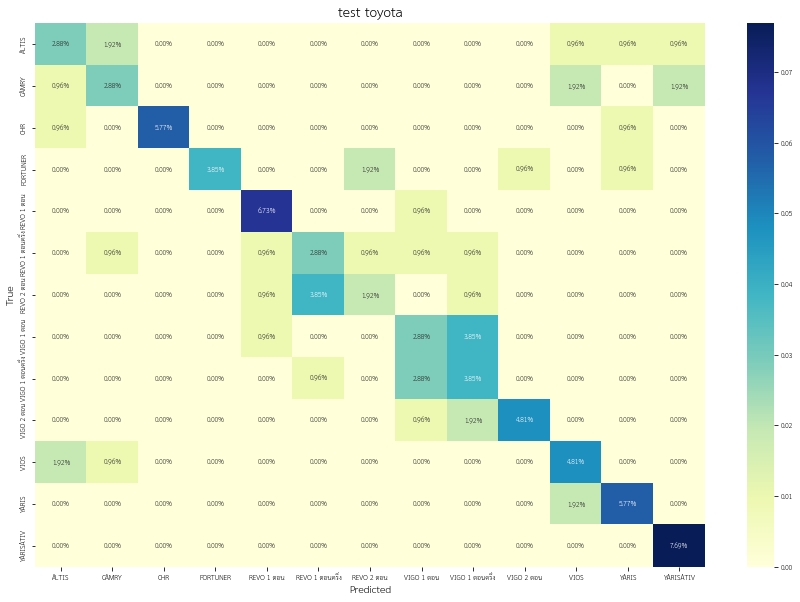

In [ ]:
print(classification_report(y_true, f_prediction))
cf_matrix1 = confusion_matrix(y_true, f_prediction)
plot_cm(cf_matrix1)
plt.title("test toyota", fontsize =20)

In [ ]:
import pandas as pd
data = {"img_name": f_name, "predict_number":f_number, "predict_name": f_prediction, "conf": f_score,"result":com}
df = pd.DataFrame(data)
df.sort_values(by=['img_name']).reset_index(drop=True)

,img_name,predict_number,predict_name,conf,result
0,TEST_Toyota_ALTIS_1.jpg,13,YARISATIV,0.750570,NO
1,TEST_Toyota_ALTIS_2.jpg,1,ALTIS,0.956123,YES
2,TEST_Toyota_ALTIS_3.jpg,1,ALTIS,0.941717,YES
3,TEST_Toyota_ALTIS_4.jpg,2,CAMRY,0.729185,NO
4,TEST_Toyota_ALTIS_5.jpg,11,VIOS,0.755074,NO
...,...,...,...,...,...
99,TEST_Toyota_YARIS_4.jpg,12,YARIS,0.464180,YES
100,TEST_Toyota_YARIS_5.jpg,12,YARIS,0.979494,YES
101,TEST_Toyota_YARIS_6.jpg,12,YARIS,0.948424,YES
102,TEST_Toyota_YARIS_7.jpg,11,VIOS,0.924396,NO


In [ ]:
print("%.2f" %(corr/total*100))

56.73


TEST TOYOTA VALIDATION SET

In [ ]:
# Load a random image from the images folder

# file_names = next(os.walk(IMAGE_DIR))[2]
IMAGE_DIR = "/content/drive/MyDrive/Toyota first run/val"
test_im = fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg')
y_true = []
f_name = []
f_number = []
f_prediction = []
com = []
f_score = []
corr = 0
total = 0
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
for i, im in enumerate(test_im, 1):
  image = skimage.io.imread(os.path.join(IMAGE_DIR, im))
  print("File  {}\nImage {} / {}".format(im, i, len(test_im)))

  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
  # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_class_names, r['scores'], title=im, save_path = savefig_path + 'test_honda')
  f_name.append(im) #append filename
  try:
    img_class = im.split("_")[0].replace('TOYOTA', '') #get real class name from filename. #lstrip() didn't work in this file name case(YARIS, YARISATIV)
    pred = dataset_class_names[r['class_ids'][0]]
    pred_conf = r['scores'][0]

    if img_class == 'REVO1':
      img_class = 'REVO 1 ตอน'
    elif img_class == 'REVO1-5':
      img_class = 'REVO 1 ตอนครึ่ง'
    elif img_class == 'REVO2':
      img_class = 'REVO 2 ตอน'
    elif img_class == 'VIGO1':
      img_class = 'VIGO 1 ตอน'
    elif img_class == 'VIGO1-5':
      img_class = 'VIGO 1 ตอนครึ่ง'
    elif img_class == 'VIGO2':
      img_class = 'VIGO 2 ตอน'

    f_number.append(r['class_ids'][0])
    f_prediction.append(pred) #append prediction
    f_score.append(pred_conf)
    y_true.append(img_class)


    print("Class {}\nPred  {}\nConf  {}".format(img_class, pred, pred_conf))
    if(img_class == pred):
      corr += 1
      com.append("YES")
    else:
      com.append("NO")
  except:
    f_number.append("not detect")
    f_prediction.append("not detect") 
    com.append("NO")
    f_score.append("not detect")
  
  total += 1
  print('-' * 50)

File  TOYOTAREVO1_101.jpg
Image 1 / 143
Class REVO 1 ตอน
Pred  REVO 1 ตอน
Conf  0.9659445285797119
--------------------------------------------------
File  TOYOTAALTIS_40.jpg
Image 2 / 143
Class ALTIS
Pred  ALTIS
Conf  0.9441531300544739
--------------------------------------------------
File  TOYOTAVIGO2_110.jpg
Image 3 / 143
Class VIGO 2 ตอน
Pred  VIGO 2 ตอน
Conf  0.9100624322891235
--------------------------------------------------
File  TOYOTAREVO1-5_56.jpg
Image 4 / 143
Class REVO 1 ตอนครึ่ง
Pred  REVO 1 ตอนครึ่ง
Conf  0.8284711241722107
--------------------------------------------------
File  TOYOTACHR_19.jpg
Image 5 / 143
Class CHR
Pred  CHR
Conf  0.9821495413780212
--------------------------------------------------
File  TOYOTAVIOS_69.jpg
Image 6 / 143
Class VIOS
Pred  VIOS
Conf  0.9087571501731873
--------------------------------------------------
File  TOYOTAREVO1-5_82.jpg
Image 7 / 143
Class REVO 1 ตอนครึ่ง
Pred  REVO 1 ตอนครึ่ง
Conf  0.8482173085212708
---------------------

                 precision    recall  f1-score   support

          ALTIS       1.00      0.73      0.84        11
          CAMRY       0.80      0.73      0.76        11
            CHR       0.92      1.00      0.96        11
       FORTUNER       0.90      0.82      0.86        11
     REVO 1 ตอน       0.64      0.82      0.72        11
REVO 1 ตอนครึ่ง       0.60      0.55      0.57        11
     REVO 2 ตอน       0.70      0.64      0.67        11
     VIGO 1 ตอน       0.80      0.73      0.76        11
VIGO 1 ตอนครึ่ง       0.75      0.55      0.63        11
     VIGO 2 ตอน       0.60      0.82      0.69        11
           VIOS       0.77      0.91      0.83        11
          YARIS       0.60      0.82      0.69        11
      YARISATIV       0.50      0.36      0.42        11

       accuracy                           0.73       143
      macro avg       0.74      0.73      0.72       143
   weighted avg       0.74      0.73      0.72       143



Text(0.5, 1.0, 'val toyota')

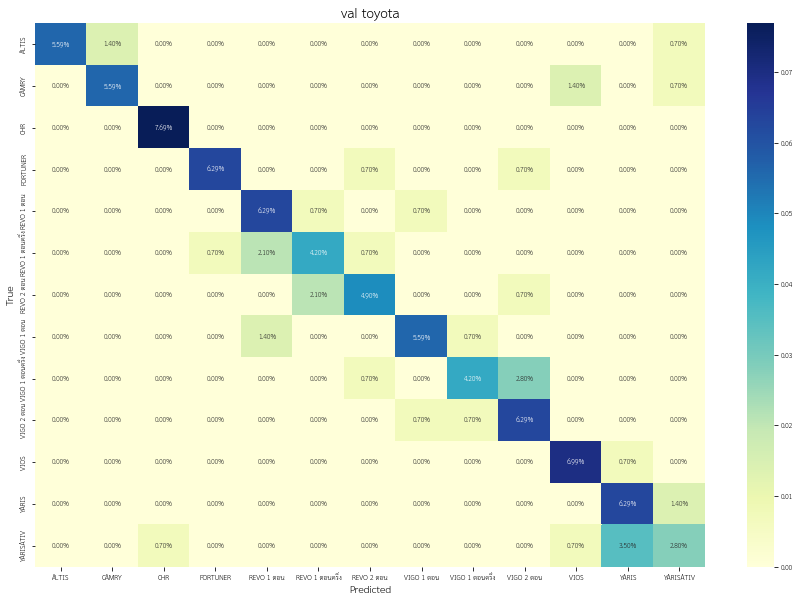

In [ ]:
print(classification_report(y_true, f_prediction))
cf_matrix2 = confusion_matrix(y_true, f_prediction)
plot_cm(cf_matrix2)
plt.title("val toyota", fontsize =20)

In [ ]:
import pandas as pd
data = {"img_name": f_name, "predict_number":f_number, "predict_name": f_prediction, "conf": f_score,"result":com}
df = pd.DataFrame(data)
df.sort_values(by=['img_name']).reset_index(drop=True)

,img_name,predict_number,predict_name,conf,result
0,TOYOTAALTIS_10.jpg,1,ALTIS,0.959443,YES
1,TOYOTAALTIS_11.jpg,1,ALTIS,0.997715,YES
2,TOYOTAALTIS_19.jpg,1,ALTIS,0.936649,YES
3,TOYOTAALTIS_26.jpg,1,ALTIS,0.989181,YES
4,TOYOTAALTIS_27.jpg,2,CAMRY,0.906207,NO
...,...,...,...,...,...
138,TOYOTAYARIS_65.jpg,13,YARISATIV,0.642077,NO
139,TOYOTAYARIS_75.jpg,12,YARIS,0.868250,YES
140,TOYOTAYARIS_8.jpg,12,YARIS,0.760025,YES
141,TOYOTAYARIS_89.jpg,13,YARISATIV,0.913389,NO


In [ ]:
print("%.2f" %(corr/total*100))

72.73
